In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('/home/beans/bespoke')

from constants import *
from imports import *
from viz_utils import *
from traj_utils import *

/home/beans/miniconda3/envs/py38/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:689: FutureWarning: This class has been deprecated. Please use CoarseDropout
  warnings.warn(
/home/beans/miniconda3/envs/py38/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:965: FutureWarning: This class has been deprecated. Please use ImageCompression
  warnings.warn(


In [2]:
chunks_range = range(SEQ_LEN-1, EPISODE_LEN, SEQ_LEN)

In [3]:
run_paths = glob.glob("/home/beans/blender_membank/*/run*", recursive=True)

In [43]:
run_path = '/home/beans/blender_membank/dataloader_11/run_19' #random.choice(run_paths)

aux = np.concatenate([np.load(f'{run_path}/aux_{i}.npy') for i in chunks_range], axis=0)
targets = np.concatenate([np.load(f'{run_path}/targets_{i}.npy') for i in chunks_range], axis=0)
maps = np.concatenate([np.load(f'{run_path}/maps_{i}.npy') for i in chunks_range], axis=0)

targets[:-1,:] = targets[1:,:] #TODO this should be moved further upstream, remove from here
aux[:-1,:] = aux[1:,:] # NOTE this stagger is verified correct
#maps[:-1,:,:,:] = maps[1:,:,:,:]

targets_all = targets
targets, wp_dists, wp_z = np.split(targets_all, 3, axis=1)

aux.shape, targets.shape, wp_dists.shape, wp_z.shape, maps.shape, run_path

((1160, 5),
 (1160, 30),
 (1160, 30),
 (1160, 30),
 (1160, 120, 80, 3),
 '/home/beans/blender_membank/dataloader_11/run_19')

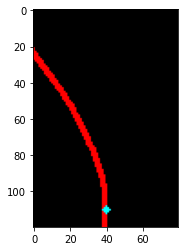

In [44]:
plt.imshow(maps[550])

In [45]:
speeds = aux[:,2]
wp_angles = gather_preds(targets, speeds)

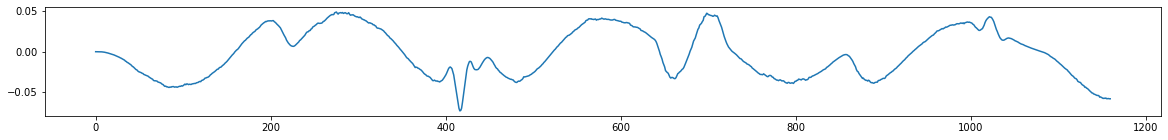

In [46]:
# steer
plt.figure(figsize=(20,2))
plt.plot(wp_angles)

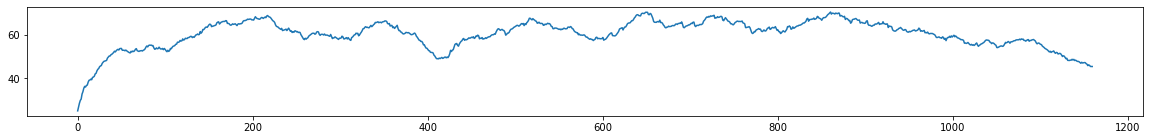

In [47]:
plt.figure(figsize=(20,2))
plt.plot(speeds)

In [48]:
ix = 1000

In [49]:
t = smooth_near_wps(targets[ix])

In [50]:
xs_smoothed = np.sin(t) * wp_dists[ix]
ys_smoothed = np.cos(t) * wp_dists[ix]

xs = np.sin(targets[ix]) * wp_dists[ix]
ys = np.cos(targets[ix]) * wp_dists[ix]

In [51]:
headings_smoothed = get_headings_from_traj(t, wp_dists[ix])
headings = get_headings_from_traj(targets[ix], wp_dists[ix])

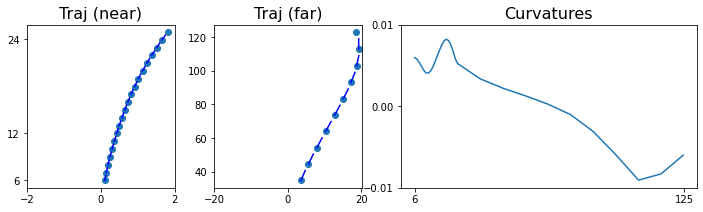

In [52]:
fig = get_pts_and_headings_fig(t, wp_dists[ix], headings_smoothed, get_curvatures_from_headings(smooth_near_wps(headings_smoothed)))

<BarContainer object of 10 artists>

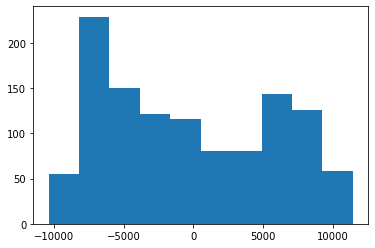

In [53]:
# Torque
torque = np.degrees(wp_angles) * speeds**2
plt.hist(torque)[2]

<BarContainer object of 10 artists>

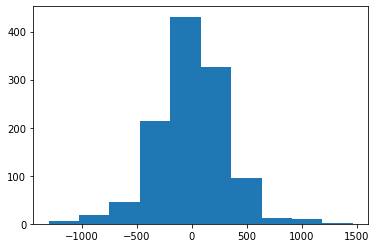

In [54]:
plt.hist(torque[1:]-torque[:-1])[2]

In [55]:
img_paths = sorted(glob.glob(f"{run_path}/imgs/*"))

In [56]:
height, width, channels = cv2.imread(img_paths[0]).shape #processed_imgs[0].shape
w2 = width//2
h2 = height//2

fps = 20

video = cv2.VideoWriter(f'/home/beans/bespoke_vids/sim/for_model_5.17.avi', cv2.VideoWriter_fourcc(*"MJPG"), fps, (width,height))

for i in range(len(img_paths)-1):

    img = cv2.imread(img_paths[i])
    
    # wps
    img = draw_wps(img, targets[i])
     
    # Guidelines
    img[:,w2-1:w2+1,:] -= 20 # darker line vertical center
    img[h2-1:h2+1:,:,:] -= 20 # darker line horizontal center
    
    img[:,-80:,:] = np.fliplr(maps[i])
    
    video.write(img)
    
video.release()

In [18]:
from viz_utils import make_vid

imgs = np.stack([cv2.imread(f)[:,:,::-1] for f in img_paths]).astype(np.uint8)

for i in range(len(imgs)):
    imgs[i,:,-MAP_WIDTH:,:] = np.fliplr(maps[i])

aux_vid = aux.copy()
#aux_vid[:,:2] = 0 # zeroing out pitch and yaw

run_id = "sim"
model_stem = "9.24_avg"
rollout_data = make_vid(run_id, model_stem, imgs, aux_vid, targets=targets, add_charts=False)

(1160, 30) (1160, 1, 15, 80) (1160, 1, 15, 80)
240 690 3
Made vid!


In [19]:
#combine_vids("8.9_avg", "8.9_avgTrain", "sim")

In [22]:
#p = get_viz_rollout(model_stem, imgs, aux_vid, do_gradcam=False)
#wp_angles_all, wp_headings_all, wp_curvatures_all, _, _, _, _, _ = p

In [20]:
wp_angles_all, wp_headings_all, wp_curvatures_all, obsnet_outs, cnn_activations, cnn_grads, rnn_activations, rnn_grads = rollout_data

(array([ 179.,  417.,  706., 2015.,  961.,  553.,  718.,  156.,   59.,
          36.]),
 array([-0.0455819 , -0.0341057 , -0.02262951, -0.01115332,  0.00032287,
         0.01179907,  0.02327526,  0.03475145,  0.04622764,  0.05770383,
         0.06918003], dtype=float32),
 <BarContainer object of 10 artists>)

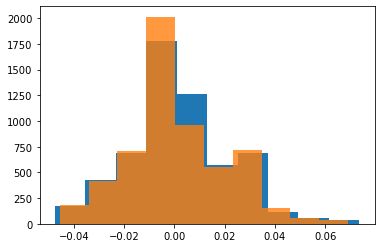

In [21]:
plt.hist(targets[:,:5].flatten())
plt.hist(wp_angles_all[:,:5].flatten(), alpha=.8)

In [22]:
obsnet_outs.shape

(1160, 3)

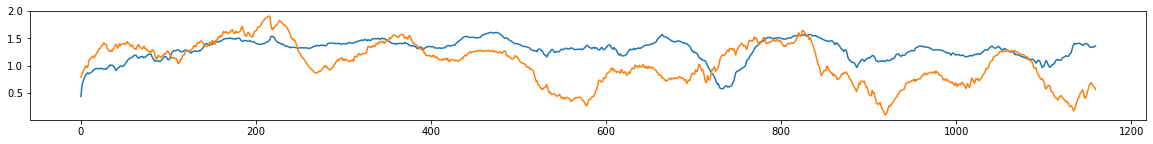

In [23]:
plt.figure(figsize=(20,2))
plt.plot(obsnet_outs[:,1])
plt.plot(obsnet_outs[:,2])

In [24]:
aux[0]

array([7.9585475e-01, 1.5869594e+00, 4.5101814e+01, 0.0000000e+00,
       3.2588083e-03], dtype=float32)

In [20]:
all_aux = []
all_wp_angles = []
all_wp_dists = []
all_run_paths = []
n_couldnt_load_runs = 0
for d in range(N_RUNNERS):
    datagen_id = ("00"+str(d))[-2:]
    for r in range(RUNS_TO_STORE_PER_PROCESS):
        run_path = f"/home/beans/blender_membank/dataloader_{datagen_id}/run_{r}"
        n_targets_paths_files = len(glob.glob(f"{run_path}/targets_*.npy"))
        targets_paths = [f'{run_path}/targets_{i}.npy' for i in chunks_range]
        
        if n_targets_paths_files < len(targets_paths):
            n_couldnt_load_runs += 1
            continue
            
        aux = np.concatenate([np.load(f'{run_path}/aux_{i}.npy') for i in chunks_range], axis=0)
        targets = np.concatenate([np.load(p) for p in targets_paths], axis=0)
        
        wp_angles, wp_dists, wp_zs = np.split(targets, 3, axis=1)
        
        all_aux.append(aux)
        all_wp_angles.append(wp_angles)
        all_wp_dists.append(wp_dists)
        all_run_paths.append(run_path)
        
all_aux = np.stack(all_aux, axis=0)
all_wp_angles = np.stack(all_wp_angles, axis=0)
all_wp_dists = np.stack(all_wp_dists, axis=0)

print(f"couldn't load {n_couldnt_load_runs} out of {N_RUNNERS*RUNS_TO_STORE_PER_PROCESS} runs")

couldn't load 12 out of 360 runs


In [21]:
%%time
all_headings = get_headings_from_traj_batch(all_wp_angles, all_wp_dists)

CPU times: user 5.71 s, sys: 0 ns, total: 5.71 s
Wall time: 5.71 s


In [22]:
all_curvatures = get_curvatures_from_headings_batch(all_headings)

In [23]:
all_wp_angles.shape, all_wp_dists.shape, all_headings.shape, all_curvatures.shape

((348, 1160, 30), (348, 1160, 30), (348, 1160, 30), (348, 1160, 30))

In [24]:
mm = 0
for i in range(len(all_curvatures)):
    m = abs(all_curvatures[i]).max()
    if m > .05:
        print(i, m)
        mm += 1

10 0.064541385
18 0.06954366
228 0.051050685
265 0.06347677


In [25]:
all_run_paths[337]

'/home/beans/blender_membank/dataloader_11/run_19'

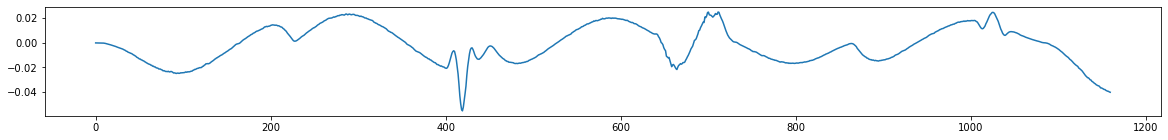

In [26]:
plt.figure(figsize=(20,2))
plt.plot(all_wp_angles[337,:,0])

<BarContainer object of 40 artists>

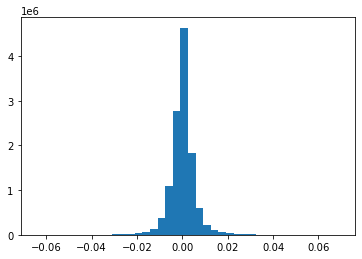

In [27]:
plt.hist(all_curvatures[:,:,:].flatten(), bins=40)[2]

In [28]:
all_torques = []
all_tds = []
for i in range(len(all_aux)):
    speeds = all_aux[i, :, 2]
    wp_angles = gather_preds(all_wp_angles[i, :, :], speeds)
    torque = np.degrees(wp_angles) * speeds**2
    all_torques.append(torque)
    all_tds.append(torque[1:]-torque[:-1])
    
all_torques = np.concatenate(all_torques)
all_tds = np.concatenate(all_tds)

<BarContainer object of 40 artists>

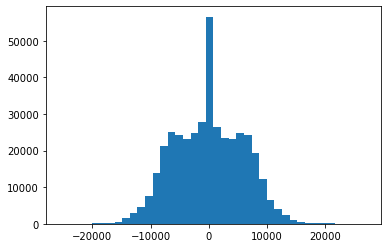

In [29]:
plt.hist(all_torques.flatten(), bins=40)[2]

<BarContainer object of 40 artists>

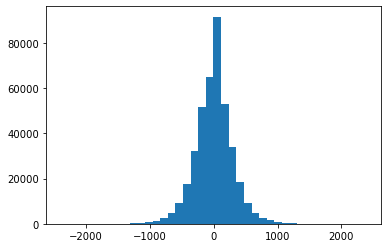

In [30]:
plt.hist(all_tds.flatten(), bins=40)[2]

In [31]:
np.quantile(abs(all_tds.flatten()), .999), np.quantile(abs(all_torques.flatten()), .999)

(1340.9834180285022, 19779.29880366182)

In [32]:
mean_dists = abs(all_wp_dists).mean(axis=0).mean(0)
mean_dists

array([  6.0009   ,   7.0009146,   8.000876 ,   9.000777 ,  10.000591 ,
        11.000339 ,  11.999986 ,  12.999544 ,  13.999013 ,  14.998335 ,
        15.997552 ,  16.996674 ,  17.99561  ,  18.994469 ,  19.993097 ,
        20.991663 ,  21.99004  ,  22.988245 ,  23.986296 ,  24.984154 ,
        34.952793 ,  44.90137  ,  54.829117 ,  64.73579  ,  74.62147  ,
        84.48712  ,  94.33461  , 104.16606  , 113.98325  , 123.787636 ],
      dtype=float32)

<BarContainer object of 40 artists>

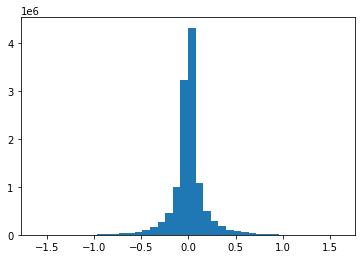

In [33]:
plt.hist(all_headings.flatten(), bins=40)[2]

In [34]:
mean_headings = abs(all_headings).mean(axis=0).mean(0)
mean_headings

array([0.02396025, 0.02777327, 0.03142287, 0.03507104, 0.0387113 ,
       0.04233847, 0.04594968, 0.04954199, 0.05311286, 0.05666003,
       0.06018323, 0.06368086, 0.06715126, 0.07059251, 0.07400471,
       0.07738619, 0.08073629, 0.08405584, 0.08734509, 0.09048808,
       0.12010952, 0.14725189, 0.17064528, 0.19036807, 0.20689474,
       0.22062452, 0.23161834, 0.23983578, 0.24585563, 0.2491454 ],
      dtype=float32)

In [35]:
mean_headings[-1] / mean_headings[0]

10.398279

In [36]:
mean_angles = abs(all_wp_angles).mean(axis=0).mean(0)
mean_angles

array([0.0116477 , 0.01367757, 0.01565671, 0.0175992 , 0.01951427,
       0.02140736, 0.02328294, 0.02514321, 0.02699019, 0.02882467,
       0.03064692, 0.03245756, 0.03425653, 0.03604405, 0.03782003,
       0.03958409, 0.04133604, 0.043076  , 0.04480399, 0.0465196 ,
       0.06298158, 0.07809851, 0.09182663, 0.1041365 , 0.11504445,
       0.12464868, 0.13306628, 0.14035773, 0.14660607, 0.15190378],
      dtype=float32)

In [37]:
mean_angles[-1] / mean_angles[0]

13.041524

In [38]:
mean_angles[0] / .015

0.776513417561849

<BarContainer object of 40 artists>

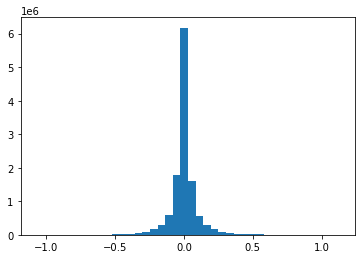

In [39]:
plt.hist(all_wp_angles.flatten(), bins=40)[2]

<BarContainer object of 40 artists>

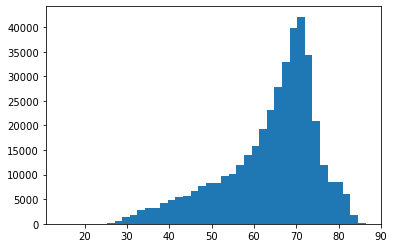

In [40]:
# speed
plt.hist(all_aux[:,:,2].flatten(), bins=40)[2]

<BarContainer object of 40 artists>

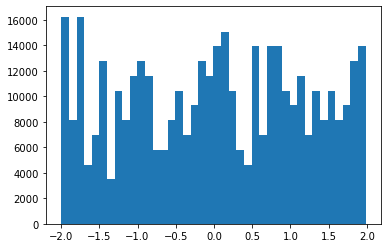

In [41]:
# pitch
plt.hist(all_aux[:,:,0].flatten(), bins=40)[2]

<BarContainer object of 40 artists>

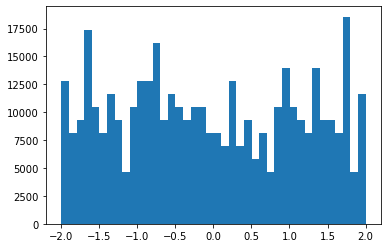

In [42]:
# yaw
plt.hist(all_aux[:,:,1].flatten(), bins=40)[2]